# Import necessary libraries

In [42]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pickle
import requests

from tensorflow import keras
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from PIL import ImageShow, Image

ImageShow.register(ImageShow.IPythonViewer(), 0)  # MyViewer will be used as a last resort

# Load dataset

In [70]:
# Load dataset
(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    read_config = tfds.ReadConfig(shuffle_seed=42) # deterministic file shuffling
)

In [71]:
# Get number of samples from each class in only train split
print(np.unique(list(ds_train.map(lambda img, label: label).as_numpy_iterator()), return_counts=True))

# Get number of samples from each class in only val split
print(np.unique(list(ds_val.map(lambda img, label: label).as_numpy_iterator()), return_counts=True))

# Get number of samples from each class in whole dataaset
print(np.unique(list(ds_train.concatenate(ds_val).map(lambda img, label: label).as_numpy_iterator()), return_counts=True))

(array([0, 1]), array([9378, 9232]))
(array([0, 1]), array([2280, 2372]))
(array([0, 1]), array([11658, 11604]))


In [72]:
def preprocess(image, label):
    ## Normalizes images: `uint8` -> `float32'
    # image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, (224, 224))
    
    # label = tf.expand_dims(label, axis=-1)
    label = tf.one_hot(label, depth=2)
    return image, label

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_train.cardinality())
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.cache()
ds_val = ds_val.batch(32)
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

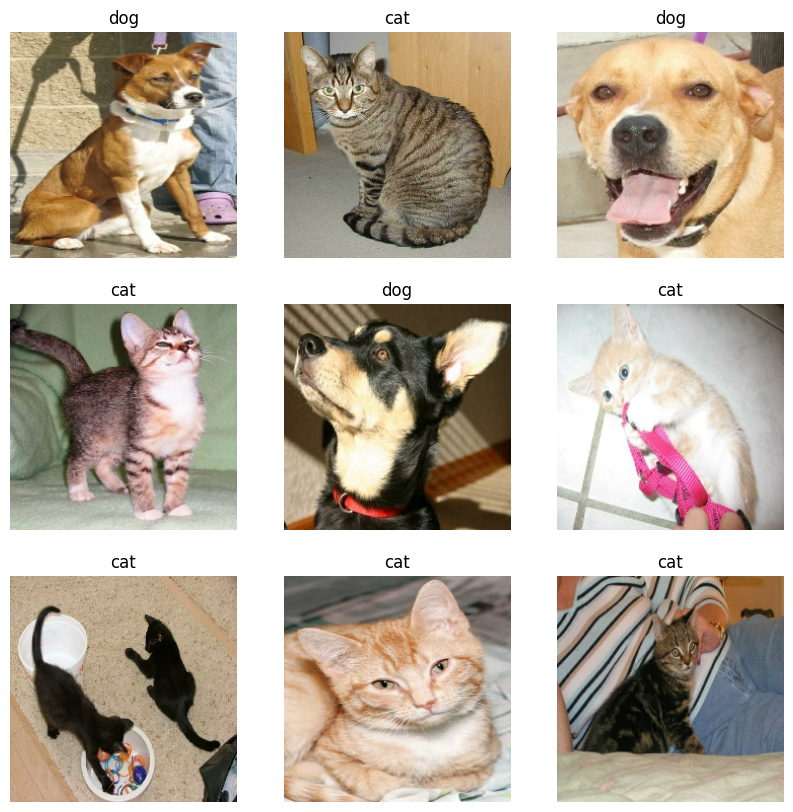

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('cat' if labels[i].numpy().argmax() == 0 else 'dog')
        plt.axis("off")

In [14]:
print(ds_info)
print(ds_train.cardinality())
print(ds_val.cardinality())

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, 

In [15]:
ds_val

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

# Create model

In [16]:
input_shape = (224, 224, 3)
fine_tune = False

# Create a model and train it on the augmented image data
inputs = keras.Input(shape=input_shape)
x = keras.applications.resnet.preprocess_input(inputs)

backbone = keras.applications.ResNet50(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)
backbone.trainable = fine_tune

x = backbone(x)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(2, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        'accuracy',
#         keras.metrics.Precision(name='precision'),
#         keras.metrics.Recall(name='recall'),
#         keras.metrics.F1Score(name='f1_score', threshold=0.5)
    ],
)

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │      4,098 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
my_callbacks = [
    # Callback to reduce lr if result doesnt improve
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_accuracy',
        mode = 'max',
        min_delta = 0.05,
        patience = 3,
        factor = 0.1,
        verbose = 1,
        cooldown = 0,
        min_lr = 1e-9
    ),

    # Callback to stop training if result doesnt improve after 5 epochs
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        min_delta=0.05,
        verbose=1,
        mode='max'
    ),

    # Callback to save model periodically
    tf.keras.callbacks.ModelCheckpoint(
        '/kaggle/working/GO_intern/baseline/model.{epoch:02d}-{val_accuracy:.2f}.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# Train model

In [19]:
hist = model.fit(
    ds_train,
    batch_size=32,
    verbose=2,
    epochs=500,
    validation_split=0.2,
    shuffle=True,
    validation_data=ds_val,
    validation_freq=1,
    callbacks=my_callbacks
)

Epoch 1/500


I0000 00:00:1723832685.432915     580 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723832685.485181     580 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723832720.113283     580 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.93981, saving model to /kaggle/working/GO_intern/baseline/model.01-0.94.keras
582/582 - 57s - 99ms/step - accuracy: 0.8248 - loss: 0.4000 - val_accuracy: 0.9398 - val_loss: 0.2227 - learning_rate: 1.0000e-04
Epoch 2/500

Epoch 2: val_accuracy improved from 0.93981 to 0.96152, saving model to /kaggle/working/GO_intern/baseline/model.02-0.96.keras
582/582 - 34s - 58ms/step - accuracy: 0.9525 - loss: 0.1792 - val_accuracy: 0.9615 - val_loss: 0.1444 - learning_rate: 1.0000e-04
Epoch 3/500

Epoch 3: val_accuracy improved from 0.96152 to 0.96862, saving model to /kaggle/working/GO_intern/baseline/model.03-0.97.keras
582/582 - 34s - 59ms/step - accuracy: 0.9658 - loss: 0.1303 - val_accuracy: 0.9686 - val_loss: 0.1141 - learning_rate: 1.0000e-04
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 4: val_accuracy improved from 0.96862 to 0.97313, saving model to /kaggle/working/GO_intern/baseline/model.04

# Plotting result

In [20]:
with open('/kaggle/working/GO_intern/baseline/history.pkl', 'wb') as f:
    pickle.dump(hist.history, f)

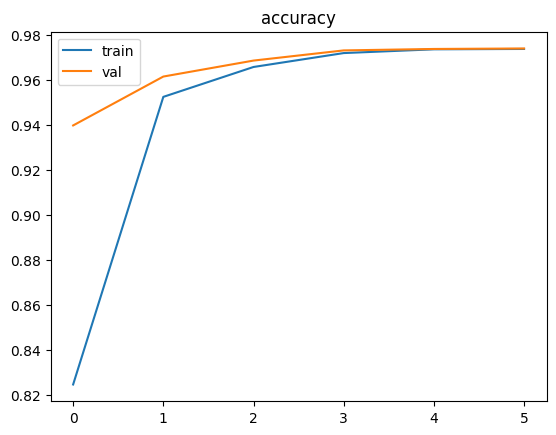

In [21]:
plt.title('accuracy')
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train', 'val'])
plt.show()


  5/146 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step

W0000 00:00:1723832905.450908     580 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step
              precision    recall  f1-score   support

         cat     0.9749    0.9719    0.9734      2280
         dog     0.9731    0.9760    0.9745      2372

    accuracy                         0.9740      4652
   macro avg     0.9740    0.9739    0.9740      4652
weighted avg     0.9740    0.9740    0.9740      4652



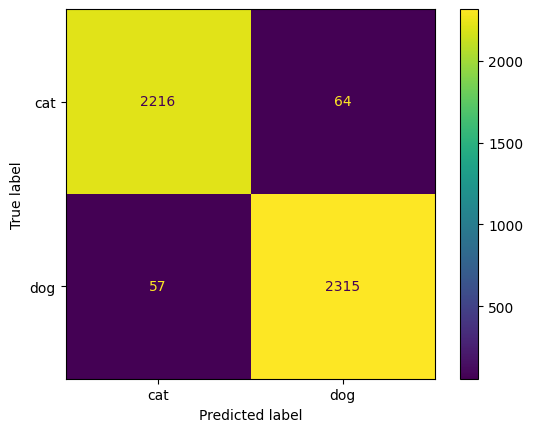

In [22]:
y_pred = model.predict(ds_val)
y = np.array(list((ds_val.unbatch().map(lambda image, label: label).as_numpy_iterator())))

print(classification_report(y.argmax(axis=-1), y_pred.argmax(axis=-1), target_names=['cat', 'dog'], digits=4))

ConfusionMatrixDisplay(confusion_matrix(y.argmax(axis=-1), y_pred.argmax(axis=-1)), display_labels=['cat', 'dog']).plot()
plt.show()

# Getting last 1, 2 percentage


## Change optimizer from SGD to Adam (0.9740 -> 0.9903)

In [27]:
model = keras.models.load_model('/kaggle/working/GO_intern/baseline/model.06-0.97.keras', compile=False, safe_mode=True)

In [28]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        'accuracy',
    ],
)

my_callbacks = [
    # Callback to reduce lr if result doesnt improve
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_accuracy',
        mode = 'max',
        min_delta = 0.05,
        patience = 3,
        factor = 0.1,
        verbose = 1,
        cooldown = 0,
        min_lr = 1e-9
    ),

    # Callback to stop training if result doesnt improve after 5 epochs
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        min_delta=0.05,
        verbose=1,
        mode='max'
    ),

    # Callback to save model periodically
    tf.keras.callbacks.ModelCheckpoint(
        '/kaggle/working/GO_intern/sgd_to_adam/model.{epoch:02d}-{val_accuracy:.2f}.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

In [29]:
hist = model.fit(
    ds_train,
    batch_size=32,
    verbose=2,
    epochs=500,
    validation_split=0.2,
    shuffle=True,
    validation_data=ds_val,
    validation_freq=1,
    callbacks=my_callbacks
)

Epoch 1/500


W0000 00:00:1723833090.012574     581 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723833123.146387     583 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.98710, saving model to /kaggle/working/GO_intern/sgd_to_adam/model.01-0.99.keras
582/582 - 64s - 110ms/step - accuracy: 0.9836 - loss: 0.0522 - val_accuracy: 0.9871 - val_loss: 0.0366 - learning_rate: 1.0000e-04
Epoch 2/500

Epoch 2: val_accuracy improved from 0.98710 to 0.98796, saving model to /kaggle/working/GO_intern/sgd_to_adam/model.02-0.99.keras
582/582 - 34s - 59ms/step - accuracy: 0.9890 - loss: 0.0339 - val_accuracy: 0.9880 - val_loss: 0.0304 - learning_rate: 1.0000e-04
Epoch 3/500

Epoch 3: val_accuracy improved from 0.98796 to 0.98968, saving model to /kaggle/working/GO_intern/sgd_to_adam/model.03-0.99.keras
582/582 - 34s - 59ms/step - accuracy: 0.9905 - loss: 0.0290 - val_accuracy: 0.9897 - val_loss: 0.0283 - learning_rate: 1.0000e-04
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 4: val_accuracy improved from 0.98968 to 0.99033, saving model to /kaggle/working/GO_intern/sgd_to_

In [30]:
with open('/kaggle/working/GO_intern/sgd_to_adam/history.pkl', 'wb') as f:
    pickle.dump(hist.history, f)

  5/146 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step

W0000 00:00:1723833409.605373     583 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step
              precision    recall  f1-score   support

         cat     0.9882    0.9908    0.9895      2280
         dog     0.9911    0.9886    0.9899      2372

    accuracy                         0.9897      4652
   macro avg     0.9897    0.9897    0.9897      4652
weighted avg     0.9897    0.9897    0.9897      4652



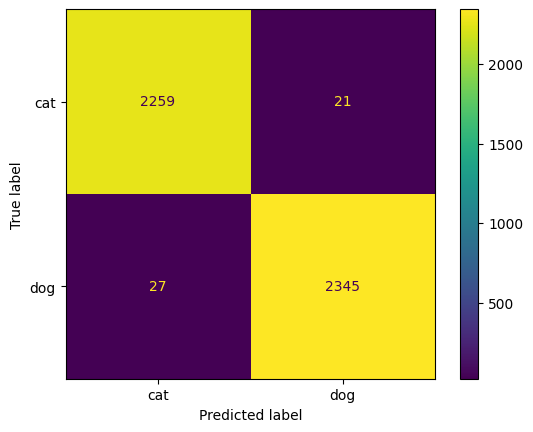

In [31]:
y_pred = model.predict(ds_val)
y = np.array(list((ds_val.unbatch().map(lambda image, label: label).as_numpy_iterator())))

print(classification_report(y.argmax(axis=-1), y_pred.argmax(axis=-1), target_names=['cat', 'dog'], digits=4))

ConfusionMatrixDisplay(confusion_matrix(y.argmax(axis=-1), y_pred.argmax(axis=-1)), display_labels=['cat', 'dog']).plot()
plt.show()

## Change optimizer SGD to RMSProp (0.9740 -> 0.9899)

In [32]:
model = keras.models.load_model('/kaggle/working/GO_intern/baseline/model.06-0.97.keras', compile=False, safe_mode=True)

In [33]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        'accuracy',
    ],
)

my_callbacks = [
    # Callback to reduce lr if result doesnt improve
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_accuracy',
        mode = 'max',
        min_delta = 0.05,
        patience = 3,
        factor = 0.1,
        verbose = 1,
        cooldown = 0,
        min_lr = 1e-9
    ),

    # Callback to stop training if result doesnt improve after 5 epochs
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        min_delta=0.05,
        verbose=1,
        mode='max'
    ),

    # Callback to save model periodically
    tf.keras.callbacks.ModelCheckpoint(
        '/kaggle/working/GO_intern/sgd_to_rmsprop/model.{epoch:02d}-{val_accuracy:.2f}.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

In [34]:
hist = model.fit(
    ds_train,
    batch_size=32,
    verbose=2,
    epochs=500,
    validation_split=0.2,
    shuffle=True,
    validation_data=ds_val,
    validation_freq=1,
    callbacks=my_callbacks
)

Epoch 1/500


W0000 00:00:1723833505.575193     581 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723833538.769557     583 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.98710, saving model to /kaggle/working/GO_intern/sgd_to_rmsprop/model.01-0.99.keras
582/582 - 51s - 88ms/step - accuracy: 0.9840 - loss: 0.0534 - val_accuracy: 0.9871 - val_loss: 0.0370 - learning_rate: 1.0000e-04
Epoch 2/500

Epoch 2: val_accuracy improved from 0.98710 to 0.98861, saving model to /kaggle/working/GO_intern/sgd_to_rmsprop/model.02-0.99.keras
582/582 - 34s - 59ms/step - accuracy: 0.9888 - loss: 0.0343 - val_accuracy: 0.9886 - val_loss: 0.0316 - learning_rate: 1.0000e-04
Epoch 3/500

Epoch 3: val_accuracy improved from 0.98861 to 0.98947, saving model to /kaggle/working/GO_intern/sgd_to_rmsprop/model.03-0.99.keras
582/582 - 34s - 59ms/step - accuracy: 0.9900 - loss: 0.0294 - val_accuracy: 0.9895 - val_loss: 0.0285 - learning_rate: 1.0000e-04
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 4: val_accuracy improved from 0.98947 to 0.98968, saving model to /kaggle/working/GO_intern

In [65]:
with open('/kaggle/working/GO_intern/sgd_to_rmsprop/history.pkl', 'wb') as f:
    pickle.dump(hist.history, f)

  5/146 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step

W0000 00:00:1723835214.365786     581 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step
              precision    recall  f1-score   support

         cat     0.9886    0.9908    0.9897      2280
         dog     0.9911    0.9890    0.9901      2372

    accuracy                         0.9899      4652
   macro avg     0.9899    0.9899    0.9899      4652
weighted avg     0.9899    0.9899    0.9899      4652



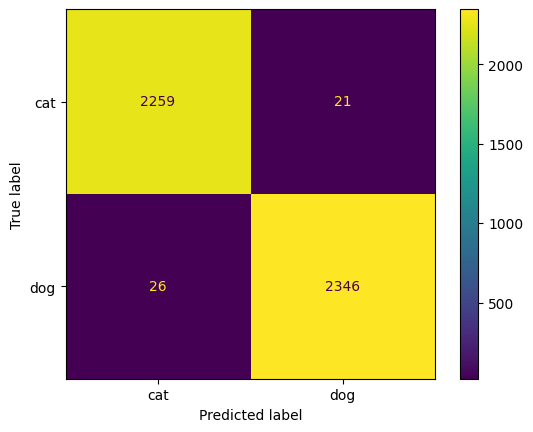

In [63]:
y_pred = model.predict(ds_val)
y = np.array(list((ds_val.unbatch().map(lambda image, label: label).as_numpy_iterator())))

print(classification_report(y.argmax(axis=-1), y_pred.argmax(axis=-1), target_names=['cat', 'dog'], digits=4))

ConfusionMatrixDisplay(confusion_matrix(y.argmax(axis=-1), y_pred.argmax(axis=-1)), display_labels=['cat', 'dog']).plot()
plt.show()

# Testing on Internet image

In [ ]:
model = keras.models.load_model('/kaggle/working/GO_intern/sgd_to_adam/model.04-0.99.keras', compile=False, safe_mode=True)

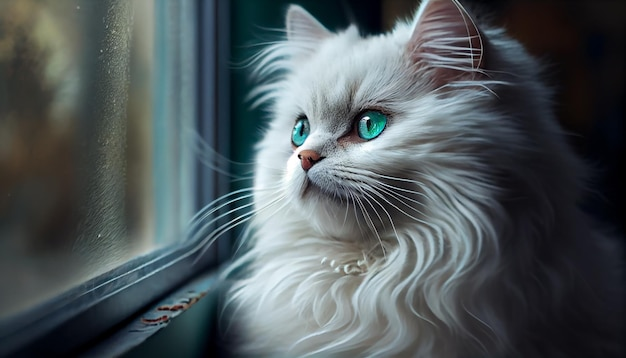

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction: cat


In [58]:
img = Image.open(requests.get('https://img.freepik.com/free-photo/cute-domestic-kitten-sits-window-staring-outside-generative-ai_188544-12519.jpg', stream=True).raw)
img.show()

img = keras.utils.img_to_array(img)
img = tf.image.resize(img, (224, 224))
img = tf.expand_dims(img, 0)

print(f'Prediction: {"cat" if model.predict(img).argmax(axis=-1)[0] == 0 else "dog"}')

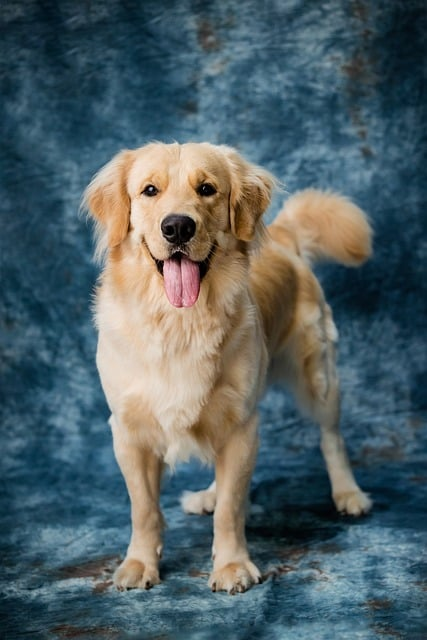

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction: dog


In [62]:
img = Image.open(requests.get('https://cdn.pixabay.com/photo/2023/08/18/15/02/dog-8198719_640.jpg', stream=True).raw)
img.show()

img = keras.utils.img_to_array(img)
img = tf.image.resize(img, (224, 224))
img = tf.expand_dims(img, 0)

print(f'Prediction: {"cat" if model.predict(img).argmax(axis=-1)[0] == 0 else "dog"}')